<a href="https://colab.research.google.com/github/Indranil-Sarmah/CA600-Mini-Project-Impact-of-Covid19-Data-Analysis/blob/master/CA600_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COVID-19 Impact Data Analysis ( Mini Project )  MCA / 10011 /19 :**

Currently the entire world is experiencing the desolation and
devastation of a deadly virus, the new disease of COVID-19,
emerging from the new coronavirus SARS-CoV 2, has spread
throughout the world, affecting more than 200 countries and
hundreds of people, with discouraging morbidity and mortality
figures.


As this project is based on Data Analysis So it will include the process of gathering, cleaning, transforming and modeling of data with the goal of discovering useful information, suggesting conclusions and to provide some support decision-making from the obtained insights.


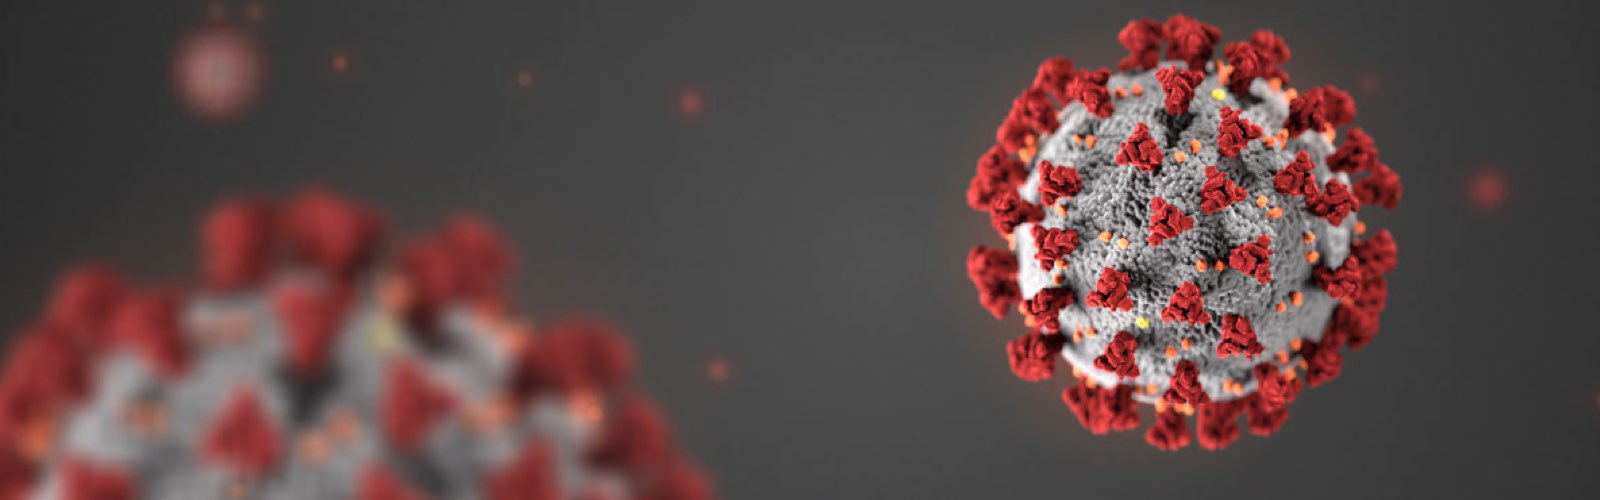

### **Importing all the required libraires**

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns
import datetime
import requests
import warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pz

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json
from pandas import DataFrame as df

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Basic Covid-19 Data (from website)**


Data from 

https://www.worldometers.info/coronavirus/

https://www.covid19india.org/

In [2]:
# Grab all data from URL
web_page = requests.get("https://www.worldometers.info/coronavirus")
soup = BeautifulSoup(web_page.text, 'html.parser')
# print(soup.prettify()) # Get source from site
html = requests.get('https://api.covid19india.org/state_test_data.json')
state_json_data = json.loads(html.text)

In [3]:
# Find basic data in div with class name maincounter-number
covid_data = soup.find_all("div",class_ = "maincounter-number")
# 
print("Coronavirus Cases: ", covid_data[0].text.strip())
print("Deaths: ", covid_data[1].text.strip())
print("Recovered: ", covid_data[2].text.strip())

# If I wanted world data I could search for script tags with type
# set as text/javascript
data = soup.find_all("script", {"type":"text/javascript"})
# for content in data:
#     print(content)

Coronavirus Cases:  233,576,636
Deaths:  4,779,201
Recovered:  210,399,223


# **Data Collection and Data Preprocessing (.CSV)** 

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


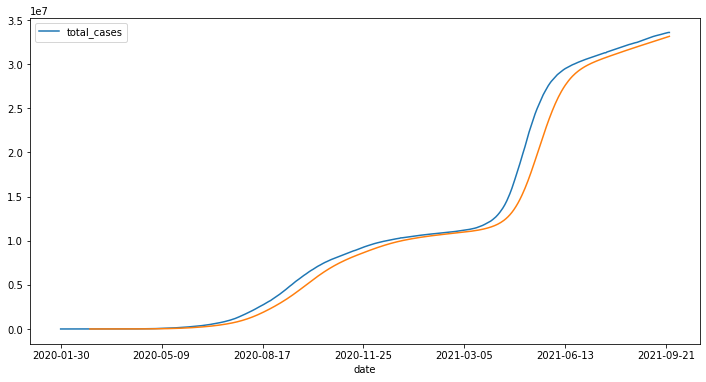

In [5]:
# Import Our World in Data CSV

owid_df = pd.read_csv('gdrive/My Drive/owid-covid-data.csv')

owid_df.columns # Show all columns

# Create Numpy array of unique countries
country_df = owid_df.location.unique()
country_df # Show countries
country_df.size # How many countries (214)

# Get indexes for location rows equal to India
indexer = owid_df[owid_df['location']=='India'].index
# Get dataframe location and total cases for India
us_tc = owid_df.loc[indexer, 'date':'total_cases']
# Delete NaN values
us_tc = us_tc.dropna()
# Set date as index
us_tc.set_index('date', inplace=True)
us_tc.plot(figsize=(12,6))

# Plot a 30 day moving average
us_tc.rolling(window=30).mean()['total_cases'].plot()

# owid_df.columns
# country_df

**1. Top 5 countries/continents with covid cases**

In [6]:
#Getting latest data
last_day_cases=owid_df[owid_df["date"]=="2021-09-22"]


#Sorting data w.r.t total_cases
max_cases_country=last_day_cases.sort_values(by="total_cases",ascending=False)
print(max_cases_country[1:6].location)
print()
print(max_cases_country[1:6].total_cases) 




6240               Asia
36374            Europe
79301     North America
113421    United States
99529     South America
Name: location, dtype: object

6240      74599880.0
36374     58412193.0
79301     51139608.0
113421    42543510.0
99529     37572221.0
Name: total_cases, dtype: float64


**2. Does Lockdown really worked for India in minimizing the covid-19 cases ?**

Index(['new_cases_per_million'], dtype='object')


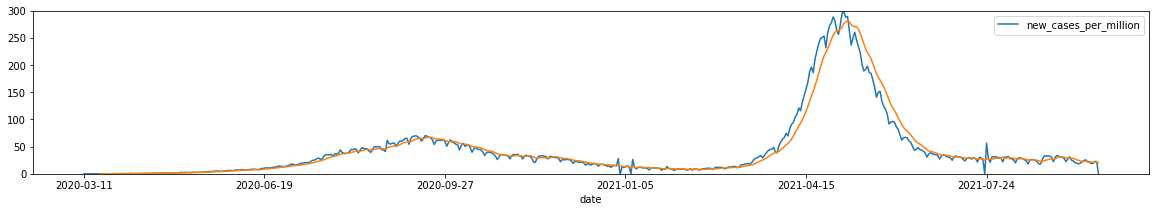

In [7]:

def plot_covid_data(country, col, plot_ma=False, y_max=150):
    
    # Get indexes for location rows equal to country name
    indexer = owid_df[owid_df['location']==country].index
    # Get dataframe location and column data for country name
    country_df = owid_df.loc[indexer, 'date':col]
    # Delete NaN values
    country_df = country_df.dropna()
    # Set date as index
    country_df.set_index('date', inplace=True)
    # Remove all columns except for what we need
    country_df.drop(country_df.columns.difference([col]), 1, inplace=True)
    country_df.plot(figsize=(20,3), ylim=[0,y_max])

    # Plot moving average if requested
    if plot_ma:
        # Plot a 30 day moving average
        country_df.rolling(window=10).mean()[col].plot()
    print(country_df.columns)
    
# Least restrictive lockdown
plot_covid_data('India', 'new_cases_per_million', True,300)
 

# owid_df.columns

**3. Median death rate of India ?**

Index(['new_deaths_per_million'], dtype='object')


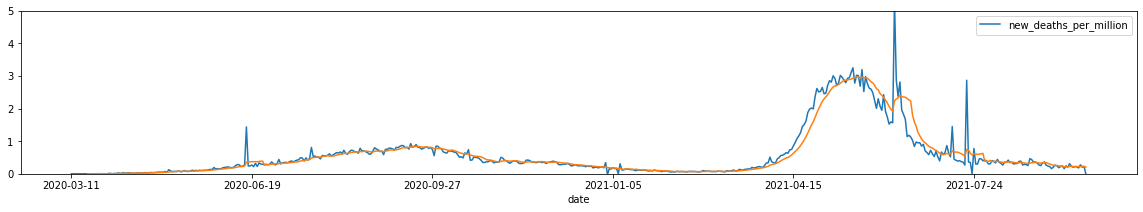

In [8]:
# India's median death rate
plot_covid_data('India', 'new_deaths_per_million', True, 5)

**5. Ongoing Covid-19 Testing Rates in Indian states ?**

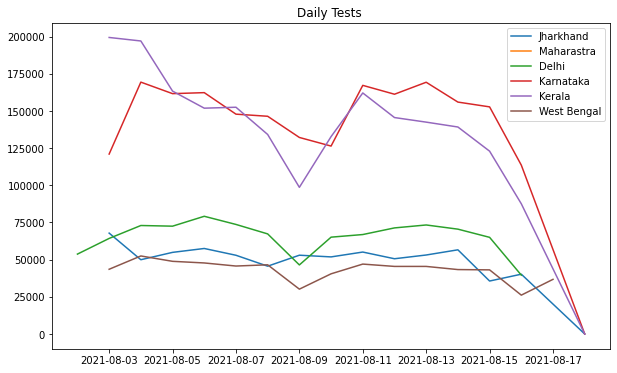

In [11]:
states = []
totaltested= []
positive = []
dates= []

for state in state_json_data['states_tested_data']:
    states.append(state['state'])
    totaltested.append(state['totaltested'])
    positive.append(state['positive'])
    dates.append(state['updatedon'])

data = pd.DataFrame({'Dates':dates, 'positive':positive, 'state': states, 'totaltested':totaltested})


data['Dates']= pd.to_datetime(data['Dates'], format = '%d/%m/%Y')
data.loc[data['positive']=='','positive'] = None
data['positive'] =data['positive'].fillna(method='ffill')
data['positive'] = data['positive'].astype(int)

data.loc[data['totaltested']=='','totaltested'] = None
data['totaltested'] =data['totaltested'].fillna(method='ffill')
data['totaltested'] = data['totaltested'].astype(int)

data = data.sort_values(by=['state', 'Dates'])
data['dailypositive'] = data['positive'].diff()
data['dailytested'] = data['totaltested'].diff()

data.loc[data['state']!=data['state'].shift(9), 'dailytested'] = data['totaltested']
data.loc[data['state']!=data['state'].shift(9), 'dailypositive'] = data['positive']


stateslist = ['Jharkhand', 'Maharastra', 'Delhi', 'Karnataka', 'Kerala',  'West Bengal']
for state in stateslist:
    statedata = data[data['state']==state]
    plt.plot(statedata['Dates'][-15:], statedata['dailytested'][-15:], label=state)
plt.rcParams["figure.figsize"] = (12,6)
plt.title('Daily Tests ')
plt.legend()
plt.show()

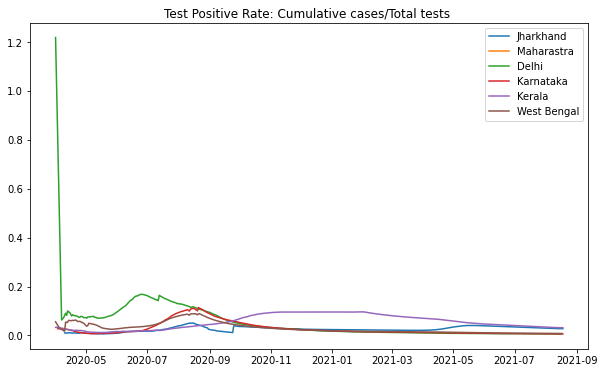

In [10]:
stateslist = ['Jharkhand', 'Maharastra', 'Delhi', 'Karnataka', 'Kerala',  'West Bengal']
for state in stateslist:
    statedata = data[data['state']==state]
    plt.plot(statedata['Dates'], statedata['positive']/statedata['totaltested'], label=state)
plt.rcParams["figure.figsize"] = (10,6)
plt.title('Test Positive Rate: Cumulative cases/Total tests ')
plt.legend()
plt.show()

6. 

7.

8.

9.

10.